In [3]:
from boostvqe.utils import *

[Qibo 0.2.9|INFO|2024-06-19 14:02:18]: Using numpy backend on /CPU:0


In [4]:
b_rand2 = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,0,10))]
eo_d = MagneticFieldEvolutionOracle(b_rand2)
eo_d_Ising = IsingNNEvolutionOracle(b_rand2,b_rand2)

In [12]:
eo_d_Ising.h.terms[-3].factors

[Z9, Z0]

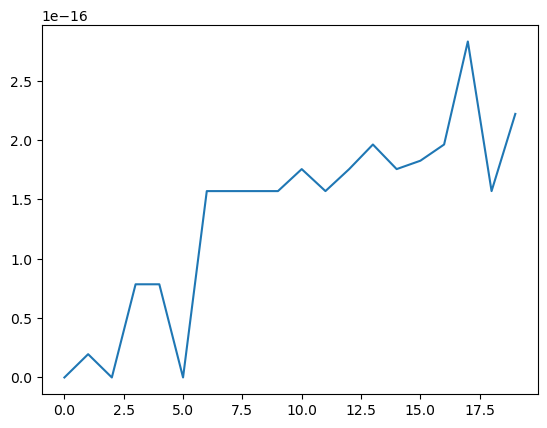

[Qibo 0.2.9|WARNING|2024-06-19 14:41:07]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


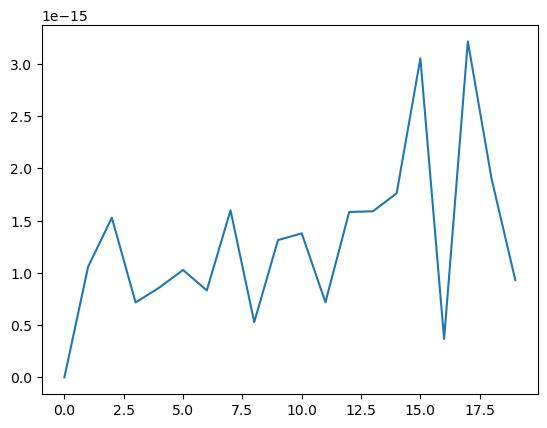

q0: ─o────o──────────────────────X─RZ─X─
q1: ─X─RZ─X─o────o───────────────|────|─
q2: ────────X─RZ─X─o────o────────|────|─
q3: ───────────────X─RZ─X─o────o─|────|─
q4: ──────────────────────X─RZ─X─o────o─


In [ ]:
def circuit(self, t_duration):
    return 0

## First we try the reduced GC

This has the cost 3x VQE + 1x Hamiltonian simulation (HS)

-14.982659482910783


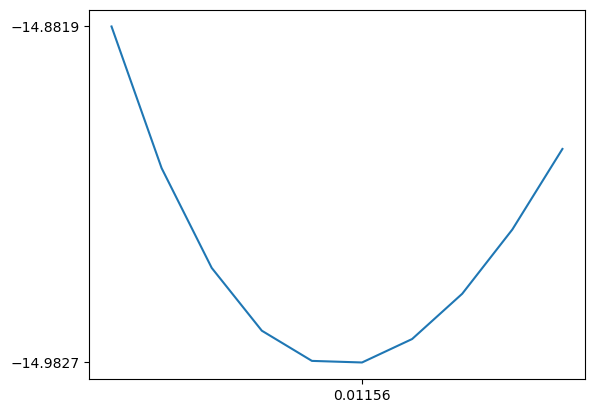

In [ ]:
losses = []
times = np.linspace(1e-3,2e-2,10)
for s in times:
    losses.append(gci.loss(s, eo_d_Ising))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gci_1 = times[np.argmin(losses)]

## Next we try the reduced GC3

This has the cost 5x VQE + 2x Hamiltonian simulation (HS)

-14.99006667910026


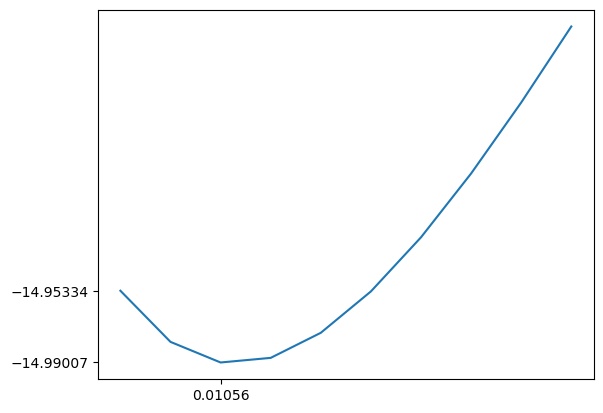

In [ ]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
losses = []
times = np.linspace(5e-3,3e-2,10)

for s in times:
    losses.append(gci.loss(s, eo_d_Ising))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gc3 = times[np.argmin(losses)]

## Finally we try the reduced GC twice

This has again the cost 5x VQE + 2x HS so anytime we try GC3 we can try to run 2x GC1

-14.9723443154465


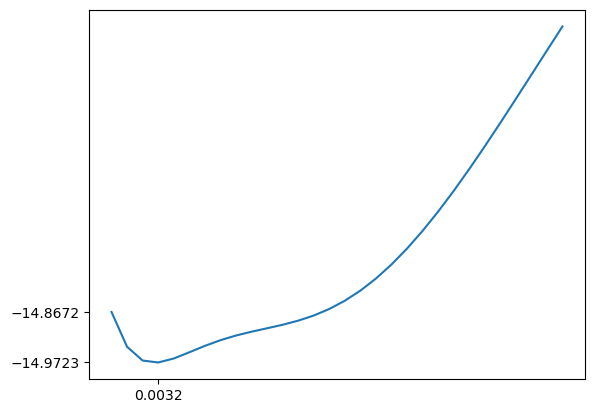

In [ ]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_reduced

c1 = gci.get_composed_circuit()
losses = []
times_double = np.linspace(1e-4,3e-2,30)
for s in times_double:
    c0 = gci.group_commutator(s, eo_d_Ising)["forwards"]
    losses.append(hamiltonian.expectation((c0+c0+c1)().state()))

plt.plot(times_double,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times_double[np.argmin(losses)]])
print(min(losses))
s_gc1_2_step = times_double[np.argmin(losses)]

## Next we study the second step


In [ ]:
c0 = gci.group_commutator(s_gci_1, eo_d_Ising)["forwards"]
v1_circ = c0+c1
hamiltonian.expectation((v1_circ)().state())

-14.982659482910783

In [ ]:

fsoe2  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v1_circ.invert(), after_circuit=v1_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe2, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)
gci2.print_gate_count_report()
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
gci2.loss()

The boosting circuit used 45 CNOT gates coming from compiled XXZ evolution and 210 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 4.5 and n_CZ/n_qubits = 21.0


-14.982659482910783

In [ ]:
gci2.print_gate_count_report()


The boosting circuit used 45 CNOT gates coming from compiled XXZ evolution and 210 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 4.5 and n_CZ/n_qubits = 21.0


-15.031792363308565


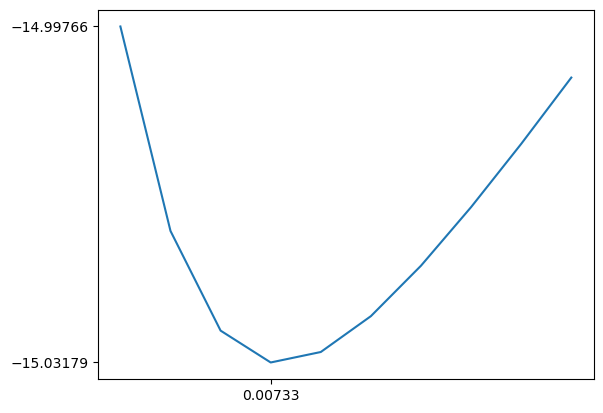

In [ ]:
gci2.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
losses = []
times = np.linspace(1e-3,2e-2,10)
b_rand2 = [1+np.sin(b)+a for a,b in zip(np.random.rand(10)*.6,np.linspace(0,1,10))]
b_rand222 = [a+b for a,b in zip(np.random.rand(10)*.006,np.linspace(4,2,10))]
eo_d = MagneticFieldEvolutionOracle(b_rand2)
eo_d_Ising = IsingNNEvolutionOracle(b_rand2,b_rand222)
for s in times:
    losses.append(gci2.loss(s, eo_d))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gci_1_2nd = times[np.argmin(losses)]

In [ ]:
gci2(s_gci_1_2nd,eo_d)
cgci2 = gci2.get_composed_circuit()

In [ ]:
gci2.loss()

-15.031792363308565

In [ ]:
fsoe3  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=cgci2.invert(), after_circuit=cgci2, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci3  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe3, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)
gci3.print_gate_count_report()
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
gci3.loss()

The boosting circuit used 315 CNOT gates coming from compiled XXZ evolution and 1050 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 31.5 and n_CZ/n_qubits = 105.0


-15.031792363308565

-15.065599416860469


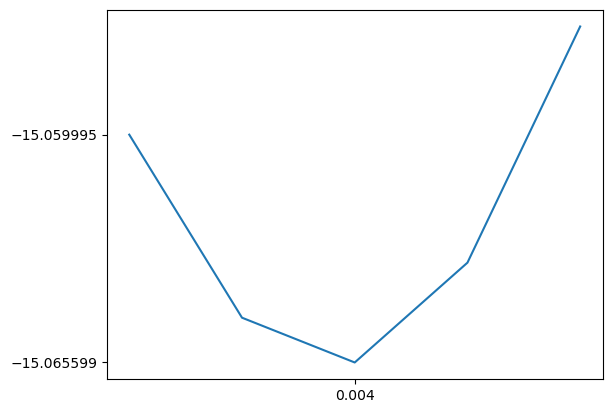

In [ ]:
gci3.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
losses = []
times = np.linspace(2e-3,6e-3,5)
b_rand2 = [1+np.sin(b)+a for a,b in zip(np.random.rand(10)*.6,np.linspace(0,1,10))]
b_rand222 = [a+b for a,b in zip(np.random.rand(10)*.006,np.linspace(4,2,10))]
eo_d = MagneticFieldEvolutionOracle(b_rand2)
eo_d_Ising = IsingNNEvolutionOracle(b_rand2,b_rand222)
for s in times:
    losses.append(gci3.loss(s, eo_d_Ising))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gci_1_2nd = times[np.argmin(losses)]

In [ ]:
gci3(s_gci_1_2nd,eo_d_Ising)
gci3.print_gate_count_report()


The boosting circuit used 1665 CNOT gates coming from compiled XXZ evolution and 5250 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 166.5 and n_CZ/n_qubits = 525.0


In [ ]:
c = gci3.get_composed_circuit()


In [ ]:
losses = []
ising = IsingNNEvolutionOracle([1]*10,[1]*10)
parity = hamiltonians.SymbolicHamiltonian( (symbols.I(0)+symbols.Z(0))*(symbols.I(1)+symbols.Z(1))*(symbols.I(2)+symbols.Z(2))*(symbols.I(3)+symbols.Z(3))*(symbols.I(4)+symbols.Z(4))*(symbols.I(5)+symbols.Z(5))*(symbols.I(5)+symbols.Z(6))*(symbols.I(5)+symbols.Z(7))*(symbols.I(5)+symbols.Z(8)),nqubits = 10)
for s in [0.01]:#np.linspace(.05,.2,10):
    a = nqubit_XXZ_decomposition(nqubits=nqubits,t=s,delta=0.5,steps=4, order = 2)
    dd = eo_d.circuit(-s) 
    #dd = ising.circuit(-s)
    c = c + a + c.invert() + dd + c + a.invert() 

    losses.append(hamiltonian.expectation(c().state()))
plt.plot(losses)
min(losses)

In [ ]:


print(np.min(losses))
f = fields[np.argmin(losses)]
s = steps[np.argmin(losses)]


In [ ]:
gci.count_CNOTs(c0+c0+c1)

90

In [ ]:
gci.count_CZs(c0+c0+c1)

350

In [ ]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced


-14.973283138160568

-14.975424658560431


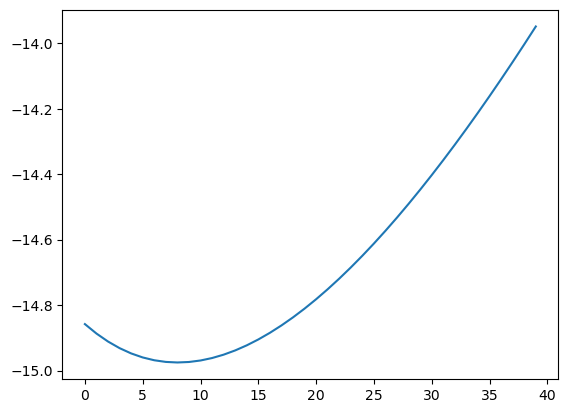

In [ ]:
losses = []
for s in np.linspace(1e-4,0.1,40):
    losses.append(gci.loss(s, MagneticFieldEvolutionOracle(f)))

print(min(losses))
plt.plot(losses)

In [ ]:
(-15.0657-target_energy)/target_energy

-0.01377515814602008

In [ ]:
losses = []
times = np.linspace(1e-5,1e-2,19)
b_rand2 = [a+b for a,b in zip(np.random.rand(10)*.001,np.linspace(1,0,10))]
for s in times:
    c2 = gci3.group_commutator(s,MagneticFieldEvolutionOracle(f))["forwards"]
    losses.append(gci3.h_ref.expectation((c2+c2+c)().state()))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])

NameError: name 'gci3' is not defined

In [ ]:
gci3.count_CNOTs(c2+c2+c)

135

In [ ]:
gci3.count_CZs(c2+c2+c)

490

In [ ]:
v1_circ = c2+c2+c
fsoe2  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v1_circ.invert(), after_circuit=v1_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe2, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)
gci2.print_gate_count_report()
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
gci2.loss()

The boosting circuit used 135 CNOT gates coming from compiled XXZ evolution and 490 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 13.5 and n_CZ/n_qubits = 49.0


-14.963433568882726

([<matplotlib.axis.XTick at 0x70418b0fe720>], [Text(0.01, 0, '0.01')])

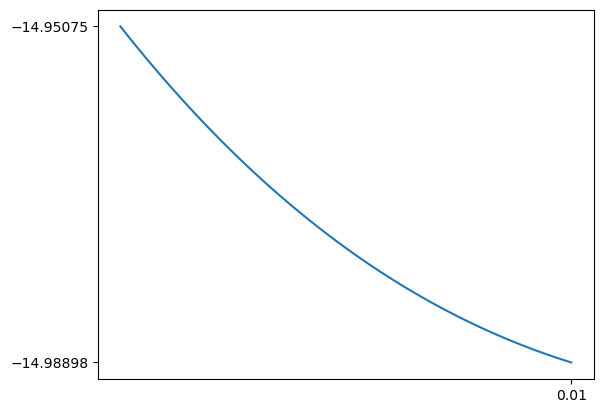

In [ ]:
losses = []
times = np.linspace(1e-5,1e-2,49)
b_rand2 = [a+b for a,b in zip(np.random.rand(10)*.001,np.linspace(1,0,10))]
mfeo = MagneticFieldEvolutionOracle(b_rand2)
for s in times:
    losses.append(gci2.loss(s,mfeo))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])

In [ ]:
losses = []
times = np.linspace(1e-5,1e-2,49)
b_rand2 = [a+b for a,b in zip(np.random.rand(10)*.001,np.linspace(1,0,10))]
mfeo = MagneticFieldEvolutionOracle(b_rand2)
for s in times:
    losses.append(gci2.loss(s,mfeo))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])

In [ ]:
losses = []
times = np.linspace(1e-5,1e-2,19)
b_rand2 = [a+b for a,b in zip(np.random.rand(10)*.001,np.linspace(1,0,10))]
for s in times:
    c2 = gci2.group_commutator(s,MagneticFieldEvolutionOracle(f))["forwards"]
    losses.append(gci3.h_ref.expectation((c2+c2+v1_circ)().state()))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])

In [ ]:
fields = []
losses = []
steps = []
for j in range(40):
    field = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,0,10))]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss = gci2.choose_step(d = eo_d,max_evals=14,step_min = 0.0001,step_max = 0.001)
    losses.append(loss)
    fields.append(field)
    steps.append(step)

plt.hist(losses)
print(np.min(losses))
plt.show()
plt.plot(steps)



In [ ]:

gci2.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced


fields = []
losses = []
steps = []
for j in range(50):
    field = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,0,10))]
    eo_d = MagneticFieldEvolutionOracle(field,name = "D(linear)")
    step,loss = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0051,step_max = 0.03)
    losses.append(loss)
    fields.append(field)
    steps.append(step)
plt.hist(losses)
print(np.min(losses))

In [ ]:
step

0.0024545454545454545

In [ ]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
gci.loss(0.0024545454545454545, MagneticFieldEvolutionOracle(b_list,name = "D(linear)"))

-14.635706745866539

In [ ]:
gci(step, eo_d)
gci.print_gate_count_report()

The boosting circuit used 45 CNOT gates coming from compiled XXZ evolution and 210 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 4.5 and n_CZ/n_qubits = 21.0


In [ ]:
gci.h_ref.expectation(gci.get_composed_circuit()().state())

-14.935548641736634

In [ ]:
v1_circ = gci.get_composed_circuit()
fsoe2  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v1_circ.invert(), after_circuit=v1_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe2, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)


In [ ]:

step,loss = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0002,step_max = 0.007)
print(loss)
print(step)

-14.979219290252477
0.002466666666666667


In [ ]:
gci2.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
step,loss = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.002,step_max = 0.007)
print(loss)
print(step)

-15.012542485184657
0.005636363636363636


In [ ]:
gci2(step, eo_d)
gci2.print_gate_count_report()

The boosting circuit used 315 CNOT gates coming from compiled XXZ evolution and 1050 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 31.5 and n_CZ/n_qubits = 105.0


In [ ]:
v2_circ = gci2.get_composed_circuit()
fsoe3  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v2_circ.invert(), after_circuit=v2_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci3  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe3, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)

In [ ]:

step,loss = gci3.choose_step(d = eo_d,max_evals=34,step_min = 0.0002,step_max = 0.007)
print(loss)
print(step)

-15.030291801630906
0.0022606060606060606


In [ ]:
gci3.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
step,loss = gci3.choose_step(d = eo_d,max_evals=34,step_min = 0.002,step_max = 0.007)
print(loss)
print(step)

-15.04753943820458
0.005333333333333333


In [ ]:
gci3(step, eo_d)
gci3.print_gate_count_report()

The boosting circuit used 1665 CNOT gates coming from compiled XXZ evolution and 5250 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 166.5 and n_CZ/n_qubits = 525.0


In [4]:
(15.08-15.27)/15.27

-0.01244269810085131